# <center>Майнор "Интеллектуальный анализ данных"</center>

# <center>Курс "Современные методы машинного обучения"</center>

# <center>Лабораторная работа №1. Ensembles methods by Sizov Denis</center>

## Данные

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [0]:
df = pd.read_csv("london_merged.csv")
df.shape

(17414, 10)

In [0]:
df.head(20)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


### Признаки

Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* "timestamp" - timestamp field for grouping the data
* "cnt" - the count of a new bike shares - **target variable**
* "t1" - real temperature in C
* "t2" - temperature in C "feels like"
* "hum" - humidity in percentage
* "wind_speed" - wind speed in km/h
* "weather_code" - category of the weather
* "is_holiday" - boolean field - 1 holiday / 0 non holiday
* "is_weekend" - boolean field - 1 if the day is weekend
* "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.  


"weathe_code" category description:
* 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity
* 2 = scattered clouds / few clouds
* 3 = Broken clouds
* 4 = Cloudy
* 7 = Rain/ light Rain shower/ Light rain
* 10 = rain with thunderstorm
* 26 = snowfall
* 94 = Freezing Fog



## Часть 1. Предобработка данных

Проверим на наличие None, и удалим если нужно

In [0]:
quality = df.columns
start_count = df.shape[0]
for i in range(len(quality)):
    for j in range(len(quality[i])):
        if df[quality[i]][j] == None:
            df.drop(df[j])
df.drop_duplicates()
print("Удалено", start_count - df.shape[0], "строк с пустыми или повторяющимися значениями")

Удалено 0 строк с пустыми или повторяющимися значениями


### Feature engeneering

Разделим критерий "timestamp", отвечающий за время, который объективно бесполезен, на признаки год, месяц, день и час

In [0]:
#quality = ['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']
quality = df.columns
pd.to_datetime(df['timestamp'])
df['timestamp_year'] = pd.DatetimeIndex(df['timestamp']).year
df['timestamp_month'] = pd.DatetimeIndex(df['timestamp']).month
df['timestamp_day'] = pd.DatetimeIndex(df['timestamp']).day
df['timestamp_hour'] = pd.DatetimeIndex(df['timestamp']).hour
df.drop('timestamp', axis=1, inplace=True)
df.head(5)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,timestamp_year,timestamp_month,timestamp_day,timestamp_hour
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,0
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,1
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,4,2
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,4,3
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,4


Также бинаризуем критерий "weather_code", приобразуя его в солнечно, облачно и тд. Сначала создадим их, а потом с помощью генератора списка изменим каждый на 0 или 1.

In [0]:
df['is_sunny'] = df['weather_code']
df['is_cloudy'] = df['weather_code']
df['is_rainy'] = df['weather_code']
df['is_snowy'] = df['weather_code']
df['is_stormy'] = df['weather_code']
df['is_frosen_fog'] = df['weather_code']

In [0]:
df['is_sunny'] = [1 if df['weather_code'][i] == 1 else 0 for i in range(len(df['is_sunny']))]
df['is_cloudy'] = [1 if df['weather_code'][i] >= 2 and df['weather_code'][i] <=4 else 0 for i in range(len(df['is_cloudy']))]
df['is_rainy'] = [1 if df['weather_code'][i] == 7 else 0 for i in range(len(df['is_rainy']))]
df['is_snowy'] = [1 if df['weather_code'][i] == 10 else 0 for i in range(len(df['is_snowy']))]
df['is_stormy'] = [1 if df['weather_code'][i] == 26 else 0 for i in range(len(df['is_stormy']))]
df['is_frosen_fog'] = [1 if df['weather_code'][i] == 94 else 0 for i in range(len(df['is_frosen_fog']))]
df.drop('weather_code', axis=1, inplace=True)
df.head(10)

,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,season,timestamp_year,timestamp_month,timestamp_day,timestamp_hour,is_sunny,is_cloudy,is_rainy,is_snowy,is_stormy,is_frosen_fog
0,182,3.0,2.0,93.0,6.0,0.0,1.0,3.0,2015,1,4,0,0,1,0,0,0,0
1,138,3.0,2.5,93.0,5.0,0.0,1.0,3.0,2015,1,4,1,1,0,0,0,0,0
2,134,2.5,2.5,96.5,0.0,0.0,1.0,3.0,2015,1,4,2,1,0,0,0,0,0
3,72,2.0,2.0,100.0,0.0,0.0,1.0,3.0,2015,1,4,3,1,0,0,0,0,0
4,47,2.0,0.0,93.0,6.5,0.0,1.0,3.0,2015,1,4,4,1,0,0,0,0,0
5,46,2.0,2.0,93.0,4.0,0.0,1.0,3.0,2015,1,4,5,1,0,0,0,0,0
6,51,1.0,-1.0,100.0,7.0,0.0,1.0,3.0,2015,1,4,6,0,1,0,0,0,0
7,75,1.0,-1.0,100.0,7.0,0.0,1.0,3.0,2015,1,4,7,0,1,0,0,0,0
8,131,1.5,-1.0,96.5,8.0,0.0,1.0,3.0,2015,1,4,8,0,1,0,0,0,0
9,301,2.0,-0.5,100.0,9.0,0.0,1.0,3.0,2015,1,4,9,0,1,0,0,0,0


Нормализуем признаки с помощью LabelEncoder, чтобы данные имели нормальные параметры

In [0]:
from sklearn.preprocessing import LabelEncoder
quality = df.columns
encoder = LabelEncoder()
for i in range(1, len(quality)):
    encoder.fit(df[quality[i]])
    df[quality[i]] = encoder.transform(df[quality[i]])
df.head(10)

,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,season,timestamp_year,timestamp_month,timestamp_day,timestamp_hour,is_sunny,is_cloudy,is_rainy,is_snowy,is_stormy,is_frosen_fog
0,182,9,16,136,10,0,1,3,0,0,3,0,0,1,0,0,0,0
1,138,9,17,136,8,0,1,3,0,0,3,1,1,0,0,0,0,0
2,134,8,17,139,0,0,1,3,0,0,3,2,1,0,0,0,0,0
3,72,7,16,142,0,0,1,3,0,0,3,3,1,0,0,0,0,0
4,47,7,12,136,11,0,1,3,0,0,3,4,1,0,0,0,0,0
5,46,7,16,136,6,0,1,3,0,0,3,5,1,0,0,0,0,0
6,51,5,10,142,12,0,1,3,0,0,3,6,0,1,0,0,0,0
7,75,5,10,142,12,0,1,3,0,0,3,7,0,1,0,0,0,0
8,131,6,10,139,14,0,1,3,0,0,3,8,0,1,0,0,0,0
9,301,7,11,142,16,0,1,3,0,0,3,9,0,1,0,0,0,0


Построим heatmap, чтобы увидеть связь между признаками

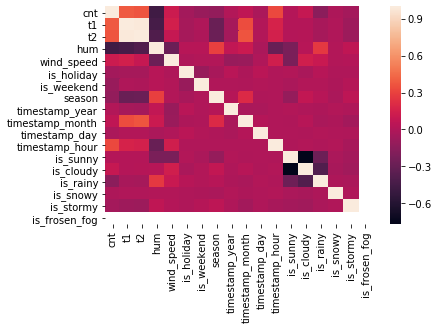

In [0]:
import seaborn as sns

X = df.values[:,1:len(df.columns)]
Y = df.values[:,0] 
sns.heatmap(df.corr())

С помощью ExtraTreesClassifier определьм значимость каждого элемента и отсортируем от большего к меньшему

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, Y)
cols = df.columns[1:len(df.columns)]

weight = pd.DataFrame()
weight["features"] = cols
weight["weights"] = model.feature_importances_
weight = weight.sort_values(by="weights", ascending = False)
weight

,features,weights
3,wind_speed,0.179225
10,timestamp_hour,0.169027
2,hum,0.146607
9,timestamp_day,0.125838
1,t2,0.124638
0,t1,0.117959
8,timestamp_month,0.057686
7,timestamp_year,0.025707
6,season,0.021946
5,is_weekend,0.010761


Как мы можем заметить самыми важными признаками оказались скорость ветра, часы и влажность. Следовательно мы не зря провели feature engeneering и разделили дату на отдельные признаки. Самыми слабыми признаками оказали все бинарные признаки. C точки зрения понимания почему эти признаки важны: легко объяснить погодные признаки такие как ветер, влажность, а следовательно дождь и температура, а также одним из важнейших признаков является часы, так как время суток в данной ситуации очень сильно влияют.

In [0]:
print("Выведем 3 последних элемента, которые имеют меньше 1 процента")
weight = weight.iloc[14:]
print("Список ненужных признаков:\n")
weight

Выведем 3 последних элемента, которые имеют меньше 1 процента
Список ненужных признаков:



,features,weights
15,is_stormy,0.000644
14,is_snowy,0.000224
16,is_frosen_fog,0.000000


### Разбиение

И последний этап подготовки - разделим все данные на 3 категории: тренировочные, калидационные и тестовые. Больше всего сделаем тренировочных, а меньше всего тестовых

In [0]:
from sklearn.model_selection import train_test_split
target = df.cnt
x, y = df.drop('cnt', axis=1), target
train_X, test_X, train_Y, test_Y,  = train_test_split(x, y, train_size=0.9, random_state=42)

In [0]:
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, train_size=0.7, random_state=42)
train_X.shape, valid_X.shape, test_X.shape

((10970, 17), (4702, 17), (1742, 17))

В итоге мы имеем: 10970 тренировочных данных, 4702 валидационных и всего 1742 тестовых

## Часть 2. Регрессия

In [0]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score


def printMetrics(prediction, valid_y):
    plt.plot(prediction[1:100], 'r-', label='Predicted')
    plt.plot(valid_y[1:100].values, 'b-', label='Correct')
    plt.xlabel("Test observations DecisionTree")
    plt.ylabel("Marks")
    plt.legend(loc='best')
    plt.show()

    MSE = metrics.mean_squared_error(y_pred=prediction, y_true=valid_y) 
    RMSE = np.sqrt(MSE)
    MAE = metrics.mean_absolute_error(y_pred=prediction, y_true=valid_y)
    R2 = metrics.r2_score(y_pred=prediction, y_true=valid_y) 

    print("Metrics:")
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}".format(MSE, RMSE, R2, MAE))
    data_metrics = (MSE, RMSE, MAE, R2)

    return data_metrics

MSE - Физического смысла не имеет, но чем ближе к нулю, тем модель лучше.

RMSE - является квадратным корнем MSE. Удобнее так так имеет меньшие величины

R2 - характеризует степень сходства исходных данных и предсказанных. В отличии от MSE не зависит от единиц измерения данных, поэтому поддается сравнению.

MAPE призван придать модели еще более наглядный смысл. Расшифровывается выражение как средняя абсолютная ошибка в процентах

MAE - Метрика измеряет среднюю сумму абсолютной разницы между фактическим значением и прогнозируемым значением


### Гребневая регрессия

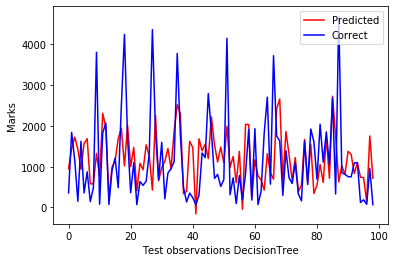

Metrics:
MSE:   841714.9407890835
RMSE:  917.4502388626228
R2:    0.3015233399940601
MAE:   661.2382093491376

Среднее значение Cross-validation = 0.32449037286688404


In [0]:
from sklearn import linear_model

ridgeModel = linear_model.RidgeCV()    
ridgeModel.fit(train_X, train_Y)   
prediction = ridgeModel.predict(valid_X)

ridge_metrics = printMetrics(prediction, valid_Y)
print("\nСреднее значение Cross-validation =", cross_val_score(ridgeModel, train_X, train_Y).mean())

### Лассо-регрессия

14.736874050169144


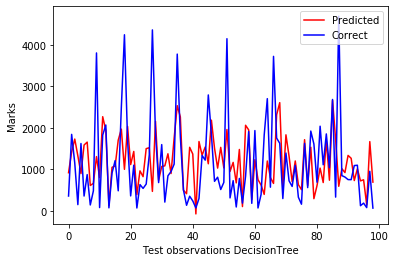

Metrics:
MSE:   848944.9198435374
RMSE:  921.3820705025345
R2:    0.2955237178213401
MAE:   661.3308747847865

Среднее значение Cross-validation = 0.32050534231096106


In [0]:
lassoModel = linear_model.LassoCV()
lassoModel.fit(train_X, train_Y)    
print(lassoModel.alpha_) 
prediction = lassoModel.predict(valid_X)

lasso_metrics = printMetrics(prediction, valid_Y)
print("\nСреднее значение Cross-validation =", cross_val_score(lassoModel, train_X, train_Y).mean())

Линейные регрессии дают ужасные результаты на этой выборке по всем метрикам.

### Decision trees

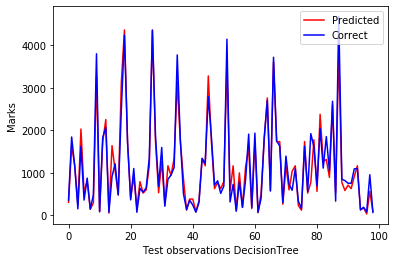

Metrics:
MSE:   99628.49036969958
RMSE:  315.6398111292357
R2:    0.9173257217822167
MAE:   189.10418991273102

Среднее значение Cross-validation = 0.907245464229094


In [0]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(train_X, train_Y)
prediction = tree.predict(valid_X)

DTR_metrics = printMetrics(prediction, valid_Y)
print("\nСреднее значение Cross-validation =", cross_val_score(tree, train_X, train_Y).mean())

### Random Forest

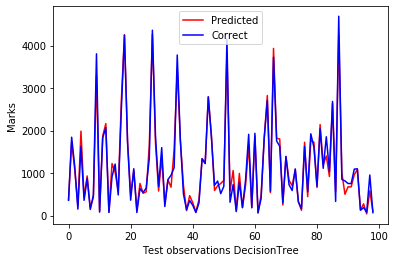

Metrics:
MSE:   55111.32864236495
RMSE:  234.75802146543353
R2:    0.9542672050914033
MAE:   138.41865163760102

Среднее значение Cross-validation = 0.945532289518579


In [0]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators=50, oob_score=True)
RF.fit(train_X, train_Y)
prediction = RF.predict(valid_X)

RandomForest_metrics = printMetrics(prediction, valid_Y)
print("\nСреднее значение Cross-validation =", cross_val_score(RF, train_X, train_Y).mean())

Деревья же показывают приличные результаты, которые в несколько раз лучше предыдущих моделей. И оба эти метода в итоге можно было бы использовать. 

### Adaboost

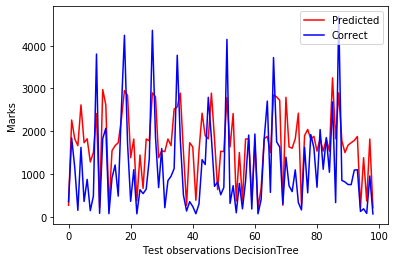

Metrics:
MSE:   673422.0042549107
RMSE:  820.622936710223
R2:    0.4411771378734016
MAE:   667.2584589228345

Среднее значение Cross-validation = 0.5008442401497741


In [0]:
from sklearn.ensemble import AdaBoostRegressor

abc = AdaBoostRegressor(n_estimators=50, learning_rate=1)
abc.fit(train_X, train_Y)
prediction = abc.predict(valid_X)

Adaboost_metrics = printMetrics(prediction, valid_Y)
print("\nСреднее значение Cross-validation =", cross_val_score(abc, train_X, train_Y).mean())

Adaboost как ни странно показывает тоже очень плохие результаты, которые не стоит использовать. И отвечая на тему ансамблей, в данной задаче они показали себя абсолютно по разному. 

### Catboost

In [0]:
pip install catboost

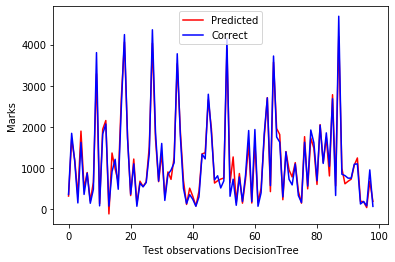

Metrics:
MSE:   51426.220085034794
RMSE:  226.77349952107454
R2:    0.9573252027485083
MAE:   140.20499740438544
0:	learn: 1064.7913506	total: 2.25ms	remaining: 2.25s
1:	learn: 1046.9557959	total: 5.11ms	remaining: 2.55s
2:	learn: 1031.4102502	total: 6.99ms	remaining: 2.32s
3:	learn: 1014.4087456	total: 8.76ms	remaining: 2.18s
4:	learn: 993.2940076	total: 10.5ms	remaining: 2.09s
5:	learn: 979.1831290	total: 12.1ms	remaining: 2.01s
6:	learn: 964.0601041	total: 13.8ms	remaining: 1.96s
7:	learn: 944.5405762	total: 15.5ms	remaining: 1.93s
8:	learn: 929.3841066	total: 17.4ms	remaining: 1.91s
9:	learn: 913.1136243	total: 19.2ms	remaining: 1.9s
10:	learn: 898.9964278	total: 21ms	remaining: 1.89s
11:	learn: 881.0896365	total: 22.8ms	remaining: 1.88s
12:	learn: 869.3345043	total: 24.5ms	remaining: 1.86s
13:	learn: 853.2697173	total: 26.3ms	remaining: 1.85s
14:	learn: 840.9218081	total: 28.3ms	remaining: 1.85s
15:	learn: 826.4881403	total: 30.1ms	remaining: 1.85s
16:	learn: 812.6868179	total: 31

In [0]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor()
cat.fit(train_X, train_Y, silent=True)
prediction = cat.predict(valid_X)

catboost_metrics = printMetrics(prediction, valid_Y)
print("\nСреднее значение Cross-validation =", cross_val_score(cat, train_X, train_Y).mean())

Модель обучения, которая стабильно, при любых параметрах показывает себя отлично и именно на ней и стоит дальше строить анализ

### Анализ методов из "коробки"

Выведем все метрики R2 для всех критериев 

In [0]:
def printALL():
    print("                        MSE                RMSE                MAE               R2")
    print("RidgeCV      = ", ridge_metrics)
    print("LassoCV      = ", lasso_metrics)
    print("DecisionTree = ", DTR_metrics)
    print("RandomForest = ", RandomForest_metrics)
    print("Adaboost     = ", Adaboost_metrics)
    print("Catboost     = ", catboost_metrics)

In [0]:
printALL()

                        MSE                RMSE                MAE               R2
RidgeCV      =  (841714.9407890835, 917.4502388626228, 661.2382093491376, 0.3015233399940601)
LassoCV      =  (848944.9198435374, 921.3820705025345, 661.3308747847865, 0.2955237178213401)
DecisionTree =  (98951.69951970504, 314.5658905852716, 188.82065534846276, 0.9178873401989975)
RandomForest =  (54543.74399591664, 233.54602115197048, 138.05999149298174, 0.9547382013977659)
Adaboost     =  (590196.6797232691, 768.2425917138863, 619.9786463176599, 0.510239648100766)
Catboost     =  (51426.220085034794, 226.77349952107454, 140.20499740438544, 0.9573252027485083)


В итоге самой удобной метрикой для определения является R2, она более менее понятна в использовании, так как нет огромных чисел, хотя если присмотреться то связь между всеми найти можно. А теперь вернемся к пункту, удаляющему 3 самых бесполезных признака, запустим методы и проверим заново

In [0]:
df.drop([x for x in weight["features"]], axis=1, inplace=True)
df.head(10)

,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,season,timestamp_year,timestamp_month,timestamp_day,timestamp_hour,is_sunny,is_cloudy,is_rainy
0,182,9,16,136,10,0,1,3,0,0,3,0,0,1,0
1,138,9,17,136,8,0,1,3,0,0,3,1,1,0,0
2,134,8,17,139,0,0,1,3,0,0,3,2,1,0,0
3,72,7,16,142,0,0,1,3,0,0,3,3,1,0,0
4,47,7,12,136,11,0,1,3,0,0,3,4,1,0,0
5,46,7,16,136,6,0,1,3,0,0,3,5,1,0,0
6,51,5,10,142,12,0,1,3,0,0,3,6,0,1,0
7,75,5,10,142,12,0,1,3,0,0,3,7,0,1,0
8,131,6,10,139,14,0,1,3,0,0,3,8,0,1,0
9,301,7,11,142,16,0,1,3,0,0,3,9,0,1,0


In [0]:
printALL()

                        MSE                RMSE                MAE               R2
RidgeCV      =  (841714.9407890835, 917.4502388626228, 661.2382093491376, 0.3015233399940601)
LassoCV      =  (848944.9198435374, 921.3820705025345, 661.3308747847865, 0.2955237178213401)
DecisionTree =  (98951.69951970504, 314.5658905852716, 188.82065534846276, 0.9178873401989975)
RandomForest =  (54543.74399591664, 233.54602115197048, 138.05999149298174, 0.9547382013977659)
Adaboost     =  (590196.6797232691, 768.2425917138863, 619.9786463176599, 0.510239648100766)
Catboost     =  (51426.220085034794, 226.77349952107454, 140.20499740438544, 0.9573252027485083)


Как мы можем заметить линейные моли и catboosts вообще не поменяли свое значение. Adaboost сделал самое большое падение на 0.027 по R2. Остальные поменяли на минимум в какую-то из сторон (+ или -). Следовательно эти параметры можно удалить, так как они не дают существунных изменений в результатах, но при этом занимают большой объем памяти.

Теперь прогоним также для проверки действия нормализации. Запустим код не нормализую данные и проверим как изменятся показатели

In [0]:
printALL()

                        MSE                RMSE                MAE               R2
RidgeCV      =  (841714.9407890835, 917.4502388626228, 661.2382093491376, 0.3015233399940601)
LassoCV      =  (848944.9198435374, 921.3820705025345, 661.3308747847865, 0.2955237178213401)
DecisionTree =  (97634.79428896027, 312.46566897654577, 188.06385768882197, 0.9189801419570994)
RandomForest =  (55587.98139021693, 235.77103594423326, 139.06710336027223, 0.9538716664082119)
Adaboost     =  (598768.9939937476, 773.8016502914346, 620.5200854253455, 0.5031261217155127)
Catboost     =  (51426.220085034794, 226.77349952107454, 140.20499740438544, 0.9573252027485083)


Рассматриваем первые 5 моделей: они все показывают довольно странные результаты, кто то увеличивается, кто то уменьшается, но в целом все показатели остаются в пределах исходных значений, скорее всего это происходит потому что у нас с самого начала не было сложных параментров, например текстовых, и все являлись числовыми, которые довольно точно отражали наши критерии. После нормализации все числа просто привелись к общему виду

И для интереса проведем последний эксперимент проанализируя данные, абсолютно без всяких изменений данных, включай разделения критериев и нормальзование

In [0]:
printALL()

                        MSE                RMSE                MAE               R2
RidgeCV      =  (841714.9407890835, 917.4502388626228, 661.2382093491376, 0.3015233399940601)
LassoCV      =  (848944.9198435374, 921.3820705025345, 661.3308747847865, 0.2955237178213401)
DecisionTree =  (99628.49036969958, 315.6398111292357, 189.10418991273102, 0.9173257217822167)
RandomForest =  (55111.32864236495, 234.75802146543353, 138.41865163760102, 0.9542672050914033)
Adaboost     =  (673422.0042549107, 820.622936710223, 667.2584589228345, 0.4411771378734016)
Catboost     =  (51426.220085034794, 226.77349952107454, 140.20499740438544, 0.9573252027485083)


Как бы не было странно, но все изменения очень малочислены и происходят в разряде тысячных. А Adaboost показал лучший показатель за все время. Catboost самый стабильный и не меняется с течением времени вообще, из этого мы можем сделать выводы, что в этом алгоритме хорошо прописаны методы оптимизации данных, которые в любом случае перекрывают лучше, чем наши преобразования

### Выбор модели и поиск лучших параметров

На основе всех вычислений хочется выделить 3 метода: 2 "деревянных" и Catboost. Они в любой ситуации показывали результаты гораздо больше, чем у остальных. Для дальнейших проверок я возьму метод Catboost за его стабильность, и за то, что у него самые высокие показатели. 

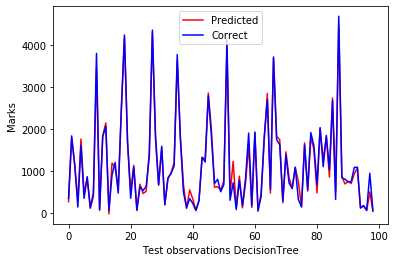

Metrics:
MSE:   33083.11532567851
RMSE:  181.88764478567123
R2:    0.9725467818432587
MAE:   108.83400734915557


In [0]:
cat = CatBoostRegressor(max_depth=12, iterations=10000)
cat.fit(train_X, train_Y, silent=True)
prediction = cat.predict(valid_X)

catboost_metrics = printMetrics(prediction, valid_Y)

Оптимальное по метрикам результат у меня получился про max_depth = 12 и iterations=10000, дальше либо результат хуже, либо происходит нехватка памяти

### Тестовая выборка

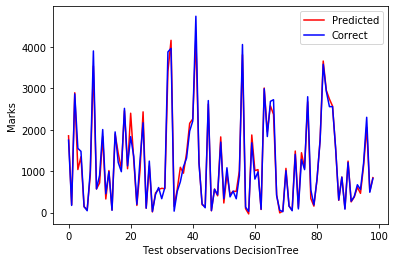

Metrics:
MSE:   37726.70712769447
RMSE:  194.23364056644377
R2:    0.9685965974404143
MAE:   111.15084281986704


In [0]:
cat = CatBoostRegressor(max_depth=12, iterations=10000)
cat.fit(train_X, train_Y, silent=True)
prediction = cat.predict(test_X)

catboost_metrics = printMetrics(prediction, test_Y)

###ИТОГИ И ВЫВОДЫ

Catboost оказался самой лучшей моделью, которая может делать слабые модели более сильными. Даже без тюнинга показывает отличные результаты, почти не отличающиеся от конечных. 

Линейные регрессии в данном примере дают очень плохой результат, они предпологают что между параметрами прямая связб. Такие результаты говорят об обратном. Деревянные модели показывают себя хорошо, это основано на том, что они пытаются найти все возможные пути решения. И если бы мы попробовали добавить параметров в них, скорее всего они бы дали еще больший результат. Они создают всесторонний анализ последствий для каждой ветви и определяют узлы принятия решений, которые требуют дальнейшего анализа. В то время как линейные модели могут занулять некоторые признаки, деревья решений учитывают все предоставленные данные.

Но в целом такие показатели анализа, особенно на линейных моделях и adaboost показывают некорректность данных. Хотя даже так нам удалось добиться больших результатов предсказания.